In [1]:
%run ../modules/qpca

<b>General implementation of a Quantum PCA for any size covariance matrices.</b>

In [2]:
import numpy as np
import scipy
from math import *
from qiskit.visualization import plot_histogram
from scipy.stats import ortho_group

In [3]:
from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
provider = IBMQ.get_provider(group='open')
provider.backends()
backend = provider.get_backend('ibmq_athens')

Generation of the covariance matrix and normalization

In [7]:
#number of features
N = 4

data = scipy.random.rand(10,N)*20
means = np.mean(data,axis=0)
u=np.ones(len(data))[None] 
u=u.reshape((len(data),1)) 
means=means.reshape((len(data[0]),1))
centered = data-np.dot(u,means.T)



covmat = np.dot(centered.transpose(),centered)
covmat=covmat/np.trace(covmat)

#covmat = [[ 0.58116991,-0.21442533],[-0.21442533 ,0.41883009]]

for r in covmat:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass
print(covmat)


eigvals, eigvecs = np.linalg.eig(covmat)
idx = np.argsort(eigvals)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

#print("&".join([str(c.round(4)) for c in eigval])+"\\")
print("Eigenvalues: ")
print(eigvals)
print("Eigenvectors: ")
print(eigvecs)
for r in eigvecs:
    #print("&".join([str(c.round(4)) for c in r])+"\\")
    pass



[[ 0.245019    0.09313585 -0.071616    0.03574989]
 [ 0.09313585  0.22063789  0.02256142  0.14435303]
 [-0.071616    0.02256142  0.28989122  0.03076787]
 [ 0.03574989  0.14435303  0.03076787  0.24445189]]
Eigenvalues: 
[0.07180329 0.16469016 0.33986836 0.42363818]
Eigenvectors: 
[[ 0.34308179 -0.67913033  0.46063842  0.4570439 ]
 [-0.75820741 -0.01097697 -0.09185463  0.6454175 ]
 [ 0.11456495 -0.51499527 -0.84948834  0.00492931]
 [ 0.5424862   0.52291622 -0.24030091  0.6119827 ]]


In [8]:
for i in range(N):
    print(f"Eigvector associated to {np.round(eigvals[i].real,5)}: [{','.join([str(j.real) for j in np.round(eigvecs.T[i],4)])} ].")



Eigvector associated to 0.0718: [0.3431,-0.7582,0.1146,0.5425 ].
Eigvector associated to 0.16469: [-0.6791,-0.011,-0.515,0.5229 ].
Eigvector associated to 0.33987: [0.4606,-0.0919,-0.8495,-0.2403 ].
Eigvector associated to 0.42364: [0.457,0.6454,0.0049,0.612 ].


In [9]:
def select_eigenvalues(eigenvalues_occurrences, bits, n):
    max_val = 1
    relevant_eigvals = []

    for i in range(n):
        eigenvalues_occurrences = [j for j in eigenvalues_occurrences if j[0] <= max_val]
        if len(eigenvalues_occurrences)<=0:
            break
        most_relevant = eigenvalues_occurrences.pop(-1)[0]
        max_val -= most_relevant - (0.5**(bits+1))
        relevant_eigvals.append(most_relevant)
    return relevant_eigvals

In [ ]:
bits = 3
shots_per_vec1 = 100
shots_per_vec2 = 1000
roundoff = 0

pool = ortho_group.rvs(dim=N)
res = None
for i in range(N):
    initial = pool[i]
    if res is None:
        res = qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff, backend=backend)
    else:
        res.merge(qpca(covmat,bits,initial= initial, req_shots = shots_per_vec1, nbitsroundoff = roundoff, backend=backend))
        
eigval_occurences = res.get_eigvals()

print(eigval_occurences)

#THRESHOLDING

relevant_eigvals = select_eigenvalues(eigval_occurences, bits-roundoff, N)

print(relevant_eigvals)

eigvec_weights = [i/sum(relevant_eigvals) for i in relevant_eigvals]


result = None
for eigval,weight in zip(relevant_eigvals,eigvec_weights):
    initial = res.eigvec_from_eigval(eigval)
    print(f"Using estimate for {eigval}: {initial}, with weight: {weight}")
    if len(initial)==0:
        continue
    if result is None:
        result = qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff, backend=backend)
    else:
        result.merge(qpca(covmat,bits,initial= initial, req_shots = int(shots_per_vec2*weight*N+1), nbitsroundoff = roundoff, backend=backend))

print(result.get_eigvals())

#RETRIEVE EIGVECTORS ESTIMATES

plot_histogram(result.get_eigvals(False))

final_eigenvalues = result.get_eigvals()

eigenvectors = [result.eigvec_from_eigval(i[0]) for i in final_eigenvalues[-N:]]

for i in eigenvectors:
    print(" ",i)
    

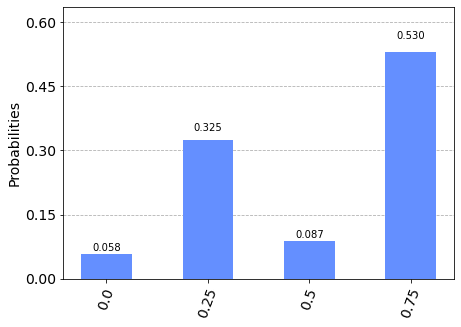

In [106]:
plot_histogram(result.get_eigvals(False))

In [110]:
K = 2

#RETRIEVE EIGVECTORS ESTIMATES
estimated_eigenvalues = sorted(select_eigenvalues(result.get_eigvals(), bits-roundoff, N))
print(estimated_eigenvalues)
estimated_eigvals = [i for i in estimated_eigenvalues[-K:]]
print("eigenvalues considered ", estimated_eigvals)
eigenvectors = [result.eigvec_from_eigval(i) for i in estimated_eigenvalues]

eigval_diag = np.diag(estimated_eigvals)
estimated_eigvecs = np.array(eigenvectors[-K:]).T

lowrank_covmat_est = np.matmul(np.matmul(estimated_eigvecs,eigval_diag),estimated_eigvecs.T)
lowrank_covmat = np.matmul(np.matmul(eigvecs[:,-K:],np.diag(eigvals[-K:])),eigvecs[:,-K:].T)
#print(np.round(estimated_eigvecs,3))
#print(np.round(eigvecs[:,-K:],3))
diff = lowrank_covmat_est - lowrank_covmat
print(np.round(lowrank_covmat_est,3))
print(np.round(lowrank_covmat,3))
print("reconstruction error l2 norm ",np.linalg.norm(diff)/np.linalg.norm(lowrank_covmat))

#VECTORS ORTHOGONALITY
U = np.matmul(estimated_eigvecs.T, estimated_eigvecs)
print("vectors orthogonality error ",np.linalg.norm(U - np.eye(K))/K)

[0.25, 0.75]
eigenvalues considered  [0.25, 0.75]
[[0.365 0.211]
 [0.211 0.635]]
[[0.369 0.168]
 [0.168 0.631]]
reconstruction error l2 norm  0.07924920521341995
vectors orthogonality error  0.026314415455551087
